#  Appendix: Walk through of MIRISim (Imager)

In this notebook, we create a scene with a circle of point sources around a central galaxy (that all fit within the Imager field of view), and run through a MIRISim simulation showing the products created at each stage.

**NOTE** this notebook must be started within  the mirisim anaconda environment. This is a pre-requist for using MIRISim, and installation instructions can be found [here](https://wiki.miricle.org/Public/MirisimInstallation).

When launching the notebook, make sure you've run the appropriate version of  

<code> conda activate mirisim</code> 


in the terminal before starting the notebook.

### Steps in this notebook:

1. Create a Scene
2. Initialise the simulation parameters
3. run the simulation
4. examine some of the outputs.

  
  

In [9]:
import os

location_of_cdbs = "/Users/niklasviebig/Desktop/Python/JWST_semester_project/trds"
os.environ['PYSYN_CDBS'] = location_of_cdbs
# End section
 
# The following section is only needed if the pandeia_refdata environment variable is not already set
# The pandeia_refdata environment variable should point to the path of the pandeia reference data
location_of_pandeia_refdata = "/Users/niklasviebig/Desktop/Python/JWST_semester_project/pandeia_data-1.7"
os.environ['pandeia_refdata'] = location_of_pandeia_refdata
# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation

#other things to be used
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

import matplotlib.pyplot as plt    # to display images
from matplotlib import colors,cm
%matplotlib inline                 

## Create a Scene

The scene created below consists of a circle of point sources surrounding a Galaxy,and a low level background, all of which fit within the main imager field of view. The point sources all have the same (blackbody) SEDs to make things simple. The galaxy as a pysynphot SED which is modified by a Keplerian velocity field.

to be able to simply add the point sources ('stars') to a scene, it first needs to be initialised with a background

#### Create the background emission

In [10]:
bg = Background(level = 'low', gradient = 5., pa = 45.)


2022-04-25 13:13:52,215 - INFO - Initializing Background


#### Create a circle of point sources

These points will be put into a 'compound target list' for simplicity later. This list needs to be initialised, so the first thing will be to create a single point source, which is placed to fall into the LRS slit.


In [11]:
# create point source objects across the Imager Field of View
def create_star(xpos,ypos):
    star = Point(Cen = (xpos,ypos))
    BBparams = {'Temp': 1e4,
                'wref': 10.,
                'flux': 7e5}
    Blackbody = sed.BBSed(**BBparams)
    star.set_SED(Blackbody)
    
    return star

    
# create a single point source at the position of the LRS slit, 
# and another at the LRS slitless position. The positions of the slit
# and slitless targets (in pixels) come from figure 2 of 
# Kendrew et al. (2015)  (MIRI PASP series #4)

center_pixel = (692,512)   # center of the array (in pixel coordinates)
slit_pixel = (321,512)     # centering pixel for the slit 
slitless_pixel = (1,529)   # centering pixel for slitless observations
pixel_scale = 0.11         #arcsec/pixel


slit_star = create_star(
    (center_pixel[0]-slit_pixel[0])*pixel_scale,
    (center_pixel[1]-slit_pixel[1])*pixel_scale)
slitless_star = create_star(
    (center_pixel[0]-slitless_pixel[0])*pixel_scale,
    (center_pixel[1]-slitless_pixel[1])*pixel_scale)

# add these two stars to the compound target list called 'stars'
stars = slit_star + slitless_star
# for writing to scene.ini file
targetlist = [slit_star,slitless_star]

# create a circle of stars, and add them to the scene
IMA_radius = 73/2.  # radius of Imager (in arcsec)
Nstars = 20         # number of stars to put in the circle
for i in range(0,Nstars):
    xp = np.cos(2*np.pi/Nstars*i)*IMA_radius
    yp = np.sin(2*np.pi/Nstars*i)*IMA_radius
    star = create_star(xp,yp)
    stars += star              # for creating a scene
    targetlist.append(star)    # for writing to file



2022-04-25 13:13:52,240 - INFO - Initializing Point
2022-04-25 13:13:52,244 - INFO - Initializing Point
2022-04-25 13:13:52,247 - INFO - Initializing Point
2022-04-25 13:13:52,249 - INFO - Initializing Point
2022-04-25 13:13:52,251 - INFO - Initializing Point
2022-04-25 13:13:52,258 - INFO - Initializing Point
2022-04-25 13:13:52,266 - INFO - Initializing Point
2022-04-25 13:13:52,269 - INFO - Initializing Point
2022-04-25 13:13:52,274 - INFO - Initializing Point
2022-04-25 13:13:52,287 - INFO - Initializing Point
2022-04-25 13:13:52,292 - INFO - Initializing Point
2022-04-25 13:13:52,294 - INFO - Initializing Point
2022-04-25 13:13:52,295 - INFO - Initializing Point
2022-04-25 13:13:52,296 - INFO - Initializing Point
2022-04-25 13:13:52,298 - INFO - Initializing Point
2022-04-25 13:13:52,299 - INFO - Initializing Point
2022-04-25 13:13:52,301 - INFO - Initializing Point
2022-04-25 13:13:52,302 - INFO - Initializing Point
2022-04-25 13:13:52,304 - INFO - Initializing Point
2022-04-25 1

#### Create the Galaxy

In [12]:

# initialise the galaxy with a position
galaxy = Galaxy(Cen = (0.,0.),n=1.,re=1.,q=0.4,pa=0)

# set the properties of the SED
PYSPsedDict = {'family': 'bkmodels', 'sedname': 'bk_b0005', 'flux': 1E+5, 'wref': 10.}
# read that dictionary into the pysynphot interpreter
sedE = wS.PYSPSed(**PYSPsedDict)
# add the SED to the galaxy
galaxy.set_SED(sedE)

# create a velocity mapping for the SED
VMAPpars = {'vrot': 200., 'Cen': (0., 0.), 'pa': 0., 'q': 0.4, 'c': 0}
VelocityMap = kinetics.FlatDisk(**VMAPpars)
# add the velocity map to the galaxy
galaxy.set_velomap(VelocityMap)

# add a line of sight velocity distribution to the galaxy
losVeloDist = kinetics.Losvd(sigma=200.,h3=0.,h4=0.)
galaxy.set_LOSVD(losVeloDist)





2022-04-25 13:13:52,327 - INFO - Initializing Galaxy
2022-04-25 13:13:52,329 - INFO - Initializing Galaxy
2022-04-25 13:13:52,330 - INFO - Initializing Galaxy
2022-04-25 13:13:52,492 - INFO - Initializing FlatDisk
2022-04-25 13:13:52,493 - INFO - Initializing Losvd


### From the components, create a scene

create a scene is as simple as adding together the targets.

In [13]:
scene = bg + stars + galaxy

# for writing to scene.ini file
targetlist.append(galaxy)

### Export the scene to an ini file and FITS

The scene can also be exported to an ini file (for future use), or a FITS file to be visualised.

Exporting to a FITS file requires specifing a number of aditional parametrs such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)

**NOTE**: export to fits currently (8/Feb/2017) doesn't work properly



In [ ]:
## export to ini file
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

os.system('rm IMA_example_scene.ini')
scene_config.write('IMA_example_scene.ini')

## export to FITS file
FOV = np.array([[-57.,57.],[-57.,57.]])   # field of view [xmin,xmax],[ymin,ymax] (in arcsec)
SpatialSampling = 0.1               # spatial sampling (in arcsec)
WavelengthRange = [5,15]            # wavelength range to process (in microns)
WavelengthSampling = 0.5           # channel width (in microns)


# overwrite = True enables overwriting of any previous version of the fits file
# with the same name as that given in the writecube command
scene.writecube(cubefits = 'IMA_example_scene.fits',
               FOV = FOV, time = 0.0,
               spatsampling = SpatialSampling,
               wrange = WavelengthRange,
               wsampling = WavelengthSampling,
               overwrite = True)   

#It's not clear why the point sources are not being written to the FITS file.


## Initialise the Simulation Parameters

This is where the parameters for the MRS simulation get set. Note that for internal consistency in MIRISim, all settings (including those not used in the MRS simulation here) must be set. Those not being used in this simulation are labelled with <code> NOT USED HERE </code> in the comments of each line

In [15]:
sim_config = SimConfig.makeSim(
    name = 'ima_simulation',    # name given to simulation
    scene = 'IMA_example_scene.ini', # name of scene file to input
    rel_obsdate = 0.0,          # relative observation date (0 = launch, 1 = end of 5 yrs)
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',  # Configure the Optical path (MRS sub-band)
    Dither = False,             # Don't Dither
    StartInd = 1,               # start index for dither pattern [NOT USED HERE]
    NDither = 2,                # number of dither positions [NOT USED HERE]
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use [NOT USED HERE]
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5,             # [NOT USED HERE]
    ima_exposures = 2,          # number of exposures
    ima_integrations = 3,       # number of integrations
    ima_frames = 5,             # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F1130W',          # Imager Filter to use
    readDetect = 'FULL'         # Portion of detector to read out
)

### Export the simulation setup to a file

In [16]:
os.system('rm IMA_simulation.ini')
sim_config.write('IMA_simulation.ini')

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.

the last step is to setup the defaults for internal things like CDPs.

In [17]:
simulator_config = SimulatorConfig.from_default()


mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

2022-04-25 13:18:22,744 - INFO - MIRISim version: 2.4.2
2022-04-25 13:18:22,755 - INFO - MIRI Simulation started.
2022-04-25 13:18:22,766 - INFO - Output will be saved to: 20220425_131822_mirisim
2022-04-25 13:18:22,771 - INFO - Storing configs in output directory.
2022-04-25 13:18:25,602 - INFO - Reading cosmic ray properties from parameter file /Users/niklasviebig/opt/anaconda3/envs/mirisim/lib/python3.9/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2022-04-25 13:18:25,628 - INFO - Reading detector properties from parameter file /Users/niklasviebig/opt/anaconda3/envs/mirisim/lib/python3.9/site-packages/miri/simulators/scasim/detector_properties.py
2022-04-25 13:18:25,827 - INFO - Storing dither pattern in output directory.
2022-04-25 13:18:25,836 - WARNING - Environment variable CDP_DIR is not set. Will look up / store CDP files at ./CDP
2022-04-25 13:18:25,855 - INFO - Setting up simulated Observation, with following settings:
2022-04-25 13:18:25,871 - INFO - Configu

2022-04-25 13:20:52,874 - INFO - Cosmic ray environment is SOLAR_MIN.
2022-04-25 13:20:52,908 - INFO - Reading cosmic ray library file: '/Users/niklasviebig/opt/anaconda3/envs/mirisim/lib/python3.9/site-packages/miri/simulators/data/cosmic_rays/CRs_SiAs_470_SUNMIN_02.fits'
2022-04-25 13:20:53,054 - INFO - Simulation control flags:
	Quantum efficiency simulation turned OFF.
	Poisson noise simulation turned ON.
	Read noise simulation turned ON.
	Reference pixels simulation turned ON.
	Bad pixels simulation turned ON.
	Dark current simulation turned ON.
	Flat-field simulation turned ON.
	Amplifier bias and gain turned ON.
	Detector non-linearity effects turned ON.
	Detector drift effects turned ON.
	Detector latency effects turned ON.
2022-04-25 13:20:53,056 - WARNING - ***Illumination map of size 1024 x 1032 is too large! Truncating to detector size of 1024 x 1024 pixels.
2022-04-25 13:20:53,063 - INFO - Input subarray mode obtained from illumination map: FULL
2022-04-25 13:20:53,064 - I

## Examine some of the results

Now that the MIRISim simulation has completed, lets examine the results. 


The first thing to note is that the outputs are placed in a date-labelled directory taking the form  <code> YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

In [18]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'ima_recommended_dither.dat', 'scene.ini', 'simulation.ini', 'mirisim.log']


The files contain the log which was also output to the terminal (<code> mirisim.log</code>) and copies of the .ini files used (or created from python inputs) to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation

The directories contain various outputs of MIRISim:

* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 

For those on the MIRI Test Team, the following link takes you to Patrick Kavanagh's ipython notebook walkthrough of the current build of the JWST pipeline

(http://miri.ster.kuleuven.be/bin/view/Internal/TutorialsPipeline)

Which is also linked from the MIRISim twiki page.

Below is a small code snippet used to draw the images.  it needs to be run, but doesn't produce any output directly (it's called later to show the output images)

In [19]:
def show_outputs(MIRISim_outputdir,output_type):
    '''
    plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    '''
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    

    hdu_index = 1
    if len(hdulist[hdu_index].data.shape) > 3:
        integ,frames,nx,ny = hdulist[hdu_index].data.shape
        image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        
        
    else:
        image = hdulist[hdu_index].data[0,:,:]
              
    norm = colors.LogNorm(image.mean() + 0.5 * image.std(), image.max(), clip=True)   
    plt.imshow(image,origin = 'lower', cmap = cm.viridis,interpolation = 'nearest',norm = norm)
    plt.title('{}'.format(infits.split('/')[-1]))
    plt.xlabel("'RA' Direction")
    plt.ylabel("'DEC' Direction")


    plt.colorbar()



### Viewing an illumination model

Below shows an example of an output illumination model

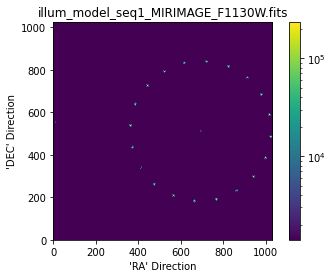

In [20]:
show_outputs(outputdir,'illum_models')


## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                    5                                                  
NAXIS4  =                    3                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

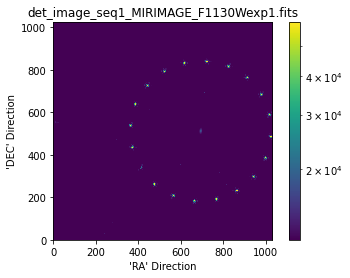

In [21]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header